# AI Project 

###  Submitted by:
Saugat Adhikari<br>
Saharsha Ojha<br>
Sanjeev Kumar Khatri<br>

---
### Data
Data was retrived from kaggle (https://www.kaggle.com/datasets/kaushil268/disease-prediction-using-machine-learning)

The original dataset consists of indicators for the symptom names however for our purposes to test an NLP workload, we first transform the data from indicators to string descriptions to emulate a situation where the symptoms come in the form of text. An example input row for this after transformation would be

*`symptoms: itching, dischromic patches, nodal skin eruptions, skin rash prognosis: fungal infection`*

Furthermore, to add a bit of natural language variation, each list of symptoms is padded with a few random phrases to imitate the possible situation of noise and a few negative phrases as well. For example, a possible variation of above list of symptoms could be.

*`symptoms: Itching. Reported signs of dischromic patches. Patient reports no patches in throat. Issues of frequent skin rash. Patient reports no spotting urination. Patient reports no stomach pain. nodal skin eruptions over the last few days.`*





In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import altair as alt
import pickle
import string
import spacy
import nltk 
import re

from sklearn.naive_bayes import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.calibration import *
from sklearn.linear_model import *
from sklearn.multiclass import *
from sklearn.svm import *
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer 
from collections import Counter
from sklearn.metrics import f1_score

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline


sns.set(style='whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

data = pd.read_csv('drive/My Drive/ai_datas/prog.csv')

# Data Preprocessing

In [3]:
data.head()

,Unnamed: 0,symptoms,prognosis
0,0,blurred and distorted vision over the last few...,Diabetes
1,1,Patient reports no nausea. Patient is experien...,Migraine
2,2,Mild case of joint pain. Occasional fatigue ex...,Hepatitis E
3,3,Issues of frequent high fever. Reported signs ...,Impetigo
4,4,Occasional phlegm experienced by patient. fati...,Common Cold


In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def clean_txt(docs):
    lemmatizer = WordNetLemmatizer() 
    # splitting into words
    speech_words = nltk.word_tokenize(docs)
    # converting to lower case
    lower_text = [w.lower() for w in speech_words]
    # preparing regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # removing punctuation from each word
    stripped = [re_punc.sub('', w) for w in lower_text]
    # removing remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filtering out stop words
    words = [w for w in words if not w in  list(STOP_WORDS)]
    # filtering out short tokens
    words = [word for word in words if len(word) > 2]
    #Stemming all the words in the sentence
    lem_words = [lemmatizer.lemmatize(word) for word in words]
    combined_text = ' '.join(lem_words)
    return combined_text

# Cleaning the text data
data['cleaned_phrase'] = data['symptoms'].apply(clean_txt)
data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Unnamed: 0,symptoms,prognosis,cleaned_phrase
0,0,blurred and distorted vision over the last few...,Diabetes,blurred distorted vision day polyuria reported...
1,1,Patient reports no nausea. Patient is experien...,Migraine,patient report nausea patient experiencing ind...
2,2,Mild case of joint pain. Occasional fatigue ex...,Hepatitis E,mild case joint pain occasional fatigue experi...
3,3,Issues of frequent high fever. Reported signs ...,Impetigo,issue frequent high fever reported sign red so...
4,4,Occasional phlegm experienced by patient. fati...,Common Cold,occasional phlegm experienced patient fatigue ...
...,...,...,...,...
4957,4957,weakness in limbs over the last few days. Repo...,Cervical spondylosis,weakness limb day reported sign neck pain evid...
4958,4958,Patient is experiencing neck pain. constipatio...,Osteoarthristis,patient experiencing neck pain constipation pr...
4959,4959,Patient is experiencing distention of abdomen....,Alcoholic hepatitis,patient experiencing distention abdomen consti...
4960,4960,hip joint pain over the last few days. Reporte...,Osteoarthristis,hip joint pain day reported sign joint pain ev...


# Normalization of data and pipeline for models

In [5]:
def NormalizedTextModel(nameOfvect):
    if nameOfvect == 'countvect':
        vectorizer = CountVectorizer()
    elif nameOfvect =='tfvect':
        vectorizer = TfidfVectorizer()

    pipelines = []
    pipelines.append((nameOfvect+'KNN' , Pipeline([('Vectorizer', vectorizer),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfvect+'CART', Pipeline([('Vectorizer', vectorizer),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfvect+'RF'  , Pipeline([('Vectorizer', vectorizer),('RF'  , RandomForestClassifier())])))
    pipelines.append((nameOfvect+'SGD'  , Pipeline([('Vectorizer', vectorizer),('SGD'  , SGDClassifier())])))
    pipelines.append((nameOfvect+'OVRC'  , Pipeline([('Vectorizer', vectorizer),('OVRC'  , OneVsRestClassifier(LogisticRegression()))])))
    pipelines.append((nameOfvect+'Bagging'  , Pipeline([('Vectorizer', vectorizer),('Bagging'  , BaggingClassifier())])))
    return pipelines

# Traing model 
def fit_model(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# Split data to training and validation set
def read_in_and_split_data(data, features,target):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

X = 'cleaned_phrase'
target_class = 'prognosis'
X_train, X_test, y_train, y_test = read_in_and_split_data(data, X, target_class)

# Model behaviour using CountVectorizer

In [6]:
sample_text_count = X_train[:10]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(sample_text_count)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(sample_text_count)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

{'occasional': 66, 'palpitation': 70, 'experienced': 29, 'patient': 71, 'report': 80, 'acidity': 2, 'nausea': 61, 'day': 19, 'issue': 47, 'frequent': 37, 'excessive': 28, 'hunger': 42, 'fatigue': 34, 'cough': 16, 'anxiety': 4, 'drying': 24, 'tingling': 106, 'lip': 51, 'itching': 48, 'reported': 81, 'sign': 85, 'headache': 40, 'sporadic': 93, 'slurred': 88, 'speech': 92, 'vomiting': 114, 'experiencing': 30, 'sweating': 99, 'irritability': 45, 'continuous': 15, 'sneezing': 90, 'present': 73, 'stiff': 95, 'neck': 62, 'movement': 58, 'stiffness': 96, 'painful': 69, 'walking': 115, 'evidence': 27, 'diarrhoea': 21, 'seen': 84, 'swelling': 101, 'joint': 49, 'muscle': 59, 'weakness': 117, 'mild': 56, 'case': 10, 'lethargy': 50, 'yellow': 119, 'urine': 112, 'receiving': 76, 'unsterile': 110, 'injection': 44, 'loss': 52, 'appetite': 5, 'dark': 18, 'blood': 7, 'transfusion': 108, 'malaise': 54, 'yellowing': 120, 'eye': 32, 'yellowish': 121, 'skin': 87, 'wasting': 116, 'weight': 118, 'pain': 68, '

In [7]:
models = NormalizedTextModel('countvect')
fit_model(X_train, y_train, models)

countvectKNN: 0.975560 (0.009761)
countvectCART: 0.954147 (0.007778)
countvectRF: 0.996724 (0.004224)
countvectSGD: 0.996976 (0.002197)
countvectOVRC: 0.999244 (0.001613)
countvectBagging: 0.982868 (0.006351)


# Model Behaviour Using Tfid

In [8]:
sample_text_Tfid = X_train[:10]

vectorizer = TfidfVectorizer()

vectorizer.fit(sample_text_Tfid)

print(vectorizer.vocabulary_)
print(vectorizer.idf_)

vector = vectorizer.transform(sample_text_Tfid)

print(vector.shape)
print(vector.toarray())

{'occasional': 66, 'palpitation': 70, 'experienced': 29, 'patient': 71, 'report': 80, 'acidity': 2, 'nausea': 61, 'day': 19, 'issue': 47, 'frequent': 37, 'excessive': 28, 'hunger': 42, 'fatigue': 34, 'cough': 16, 'anxiety': 4, 'drying': 24, 'tingling': 106, 'lip': 51, 'itching': 48, 'reported': 81, 'sign': 85, 'headache': 40, 'sporadic': 93, 'slurred': 88, 'speech': 92, 'vomiting': 114, 'experiencing': 30, 'sweating': 99, 'irritability': 45, 'continuous': 15, 'sneezing': 90, 'present': 73, 'stiff': 95, 'neck': 62, 'movement': 58, 'stiffness': 96, 'painful': 69, 'walking': 115, 'evidence': 27, 'diarrhoea': 21, 'seen': 84, 'swelling': 101, 'joint': 49, 'muscle': 59, 'weakness': 117, 'mild': 56, 'case': 10, 'lethargy': 50, 'yellow': 119, 'urine': 112, 'receiving': 76, 'unsterile': 110, 'injection': 44, 'loss': 52, 'appetite': 5, 'dark': 18, 'blood': 7, 'transfusion': 108, 'malaise': 54, 'yellowing': 120, 'eye': 32, 'yellowish': 121, 'skin': 87, 'wasting': 116, 'weight': 118, 'pain': 68, '

In [9]:
models = NormalizedTextModel('tfvect')
fit_model(X_train, y_train, models)

tfvectKNN: 0.981103 (0.006689)
tfvectCART: 0.953641 (0.012754)
tfvectRF: 0.994205 (0.004222)
tfvectSGD: 0.997984 (0.001885)
tfvectOVRC: 0.994962 (0.004362)
tfvectBagging: 0.982618 (0.008233)


# Logistic Regression model(OVRC) Fine tuning 

In [10]:
vectorizer = CountVectorizer()
X_train_1 = vectorizer.fit_transform(X_train)
model = OneVsRestClassifier(LogisticRegression())

parameters = {
    'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
}

cv = KFold(n_splits=10)

model_tunning = GridSearchCV(model, param_grid=parameters,
                            scoring='f1_weighted', cv=cv)

model_tunning.fit(X_train_1, y_train)

print (model_tunning.best_score_)
print (model_tunning.best_params_)

0.9994978699012826
{'estimator__C': 0.1}


Training Accuracy Score: 100.0%
Validation Accuracy Score: 99.9%


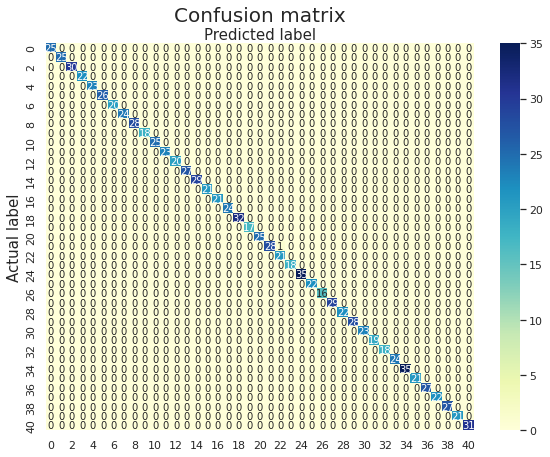

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       1.00      1.00      1.00        25
                                   Acne       1.00      1.00      1.00        30
                    Alcoholic hepatitis       1.00      1.00      1.00        22
                                Allergy       1.00      1.00      1.00        23
                              Arthritis       1.00      1.00      1.00        26
                       Bronchial Asthma       1.00      1.00      1.00        20
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        28
                    Chronic cholestasis       1.00      1.00      1.00        18
                            Common Cold       1.00      1.00      1.00        25
                           

In [11]:
def classification_metrics(model, y_test, y_pred):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion matrix', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

text_clf = Pipeline([('vect', CountVectorizer()),('OVRC'  , OneVsRestClassifier(LogisticRegression(C=0.1)))])
model = text_clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_metrics(model,y_test, y_pred)

In [12]:
a = ['joint tenderness increased pain and stiffness when you have not moved your joints for a while joints appearing slightly larger or more "knobbly" than usual a grating or crackling sound or sensation in your joints limited range of movement in your joints weakness and muscle wasting']

a = pd.DataFrame(a)

In [13]:
a = a[0].apply(clean_txt)

In [14]:
pred = model.predict(a)

In [15]:
pred

array(['Arthritis'], dtype='<U39')

# Bagging Classifier Fine Tuning

In [16]:
vectorizer = TfidfVectorizer()
X_train_1 = vectorizer.fit_transform(X_train)
model = BaggingClassifier()
n_estimators = [10, 100, 1000]

grid = dict(n_estimators=n_estimators)
cv = KFold(n_splits=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X_train_1, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.990174 using {'n_estimators': 1000}
0.978334 (0.006487) with: {'n_estimators': 10}
0.988914 (0.004935) with: {'n_estimators': 100}
0.990174 (0.003642) with: {'n_estimators': 1000}


Training Accuracy Score: 100.0%
Validation Accuracy Score: 99.2%


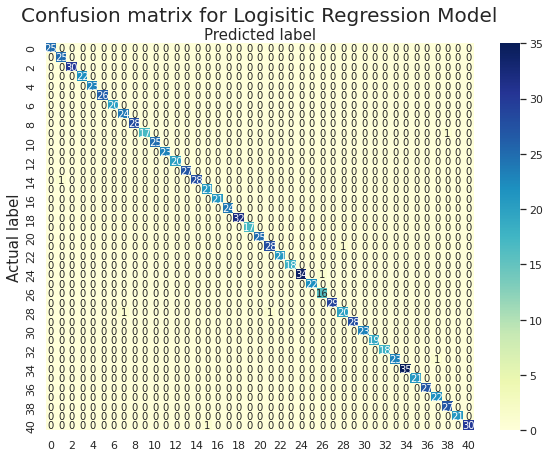

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       0.96      1.00      0.98        25
                                   Acne       1.00      1.00      1.00        30
                    Alcoholic hepatitis       1.00      1.00      1.00        22
                                Allergy       1.00      1.00      1.00        23
                              Arthritis       1.00      1.00      1.00        26
                       Bronchial Asthma       1.00      1.00      1.00        20
                   Cervical spondylosis       0.96      1.00      0.98        24
                            Chicken pox       1.00      1.00      1.00        28
                    Chronic cholestasis       1.00      0.94      0.97        18
                            Common Cold       1.00      1.00      1.00        25
                           

In [17]:
def classification_metrics(model, y_test, y_pred):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion matrix for Logisitic Regression Model', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

text_clf = Pipeline([('vect', TfidfVectorizer()),('bagging', BaggingClassifier(n_estimators=1000))])
model = text_clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_metrics(model,y_test, y_pred)

In [18]:
a = ['joint tenderness increased pain and stiffness when you have not moved your joints for a while joints appearing slightly larger or more "knobbly" than usual a grating or crackling sound or sensation in your joints limited range of movement in your joints weakness and muscle wasting']

a = pd.DataFrame(a)

In [19]:
a = a[0].apply(clean_txt)

In [20]:
pred = model.predict(a)

In [21]:
pred

array(['Arthritis'], dtype=object)

# Random Forest Classifier Fine Tuning

In [22]:
vectorizer = CountVectorizer()
X_train_1 = vectorizer.fit_transform(X_train)
model = RandomForestClassifier()

In [23]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_1, y_train)
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

Training Accuracy Score: 99.8%
Validation Accuracy Score: 99.5%


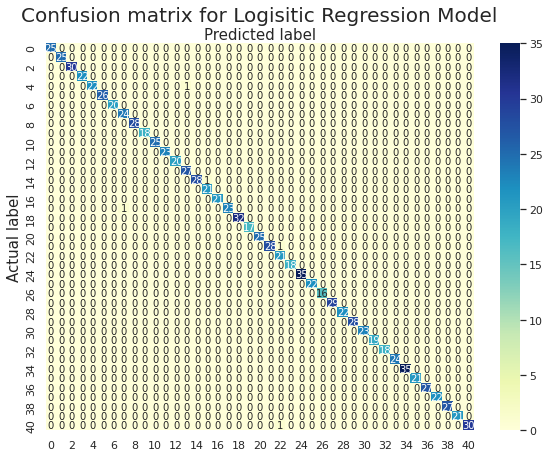

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       1.00      1.00      1.00        25
                                   Acne       1.00      1.00      1.00        30
                    Alcoholic hepatitis       1.00      1.00      1.00        22
                                Allergy       1.00      0.96      0.98        23
                              Arthritis       1.00      1.00      1.00        26
                       Bronchial Asthma       1.00      1.00      1.00        20
                   Cervical spondylosis       0.96      1.00      0.98        24
                            Chicken pox       1.00      1.00      1.00        28
                    Chronic cholestasis       1.00      1.00      1.00        18
                            Common Cold       1.00      1.00      1.00        25
                           

In [24]:
def classification_metrics(model, y_test, y_pred):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion matrix for Logisitic Regression Model', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

text_clf = Pipeline([('vect', CountVectorizer()),('RF' , RandomForestClassifier(max_features='log2', n_estimators= 200, max_depth=8, criterion='entropy'))])
model = text_clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_metrics(model,y_test, y_pred)

In [25]:
a = ['joint tenderness increased pain and stiffness when you have not moved your joints for a while joints appearing slightly larger or more "knobbly" than usual a grating or crackling sound or sensation in your joints limited range of movement in your joints weakness and muscle wasting']

a = pd.DataFrame(a)

In [26]:
a = a[0].apply(clean_txt)

In [27]:
pred = model.predict(a)

In [28]:
pred

array(['Arthritis'], dtype=object)

In [29]:
a = ['fever, fatigue, decreased appetite, nausea, vomiting, abdominal pain, dark urine, pale faeces, joint pain and jaundice (yellowing of skin and the whites of the eyes).']

a = pd.DataFrame(a)

a = a[0].apply(clean_txt)

pred = model.predict(a)

pred

array(['Hepatitis D'], dtype=object)